# Importação de Variáveis e Indicadores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

btc = pd.read_excel("../wrangled_data/serie_bitcoin.xlsx", index_col = "Data")
variaveis = pd.read_excel("../wrangled_data/variaveis.xlsx", index_col = "Data")

# Separação Treinamento - Teste

In [4]:
stop_fixo = pd.DataFrame()
stop_fixo["Retorno"] = btc["Fechamento"].pct_change()
stop_fixo["Alvo_Contínuo"] = pd.Series(stop_fixo["Retorno"])
stop_fixo["Alvo_Binário"] = np.where(stop_fixo["Retorno"] > 0, 1, 0)

STOP = 0.2
stop_fixo["Stop_Long"] = np.where(btc["Abertura"]/btc["Mínima"] > (1+STOP), 1, 0)
stop_fixo["Stop_Short"] = np.where(btc["Máxima"]/btc["Abertura"] > (1+STOP), 1, 0)
stop_fixo[["Alvo_Contínuo", "Alvo_Binário", "Stop_Long", "Stop_Short"]] = stop_fixo[["Alvo_Contínuo", "Alvo_Binário", "Stop_Long", "Stop_Short"]].shift(-1) 
stop_fixo.dropna(inplace = True)

stop_fixo

,Retorno,Alvo_Contínuo,Alvo_Binário,Stop_Long,Stop_Short
Data,,,,,
2010-07-18,0.733791,-0.058714,0.0,0.0,0.0
2010-07-19,-0.058714,-0.075083,0.0,0.0,0.0
2010-07-20,-0.075083,0.059902,1.0,0.0,0.0
2010-07-21,0.059902,-0.293713,0.0,1.0,0.0
2010-07-22,-0.293713,0.113296,1.0,0.0,1.0
...,...,...,...,...,...
2022-08-25,0.009553,-0.063454,0.0,0.0,0.0
2022-08-26,-0.063454,-0.008592,0.0,0.0,0.0
2022-08-27,-0.008592,-0.020422,0.0,0.0,0.0


In [3]:
stop_vol = pd.DataFrame()
stop_vol["Retorno"] = btc["Fechamento"].pct_change()
stop_vol["Alvo_Contínuo"] = pd.Series(stop_vol["Retorno"]).shift(-1)
stop_vol["Alvo_Binário"] = np.where(stop_vol["Retorno"] > 0, 1, 0)

# Distâncias entre a abertura e os extremos do candle
stop_vol["d_max"] = (btc["Máxima"]/btc["Abertura"])-1
stop_vol["d_min"] = (btc["Abertura"]/btc["Mínima"])-1

# Desvio-padrão amostral das distâncias da série 
sd_d_max, sd_d_min = stop_vol[ini_treino:fim_treino]["d_max"].std(), stop_vol[ini_treino:fim_treino]["d_min"].std()

stop_vol["Stop_Short"] = np.where(stop_vol["d_max"] > 2*sd_d_max, 1, 0)
stop_vol["Stop_Short"] = stop_vol["Stop_Short"].shift()

stop_vol["Stop_Long"] = np.where(stop_vol["d_min"] > 2*sd_d_min, 1, 0)
stop_vol["Stop_Long"] = stop_vol["Stop_Long"].shift()
stop_vol.dropna(inplace = True)
stop_vol.drop(["d_max", "d_min"], axis = 1, inplace = True)
stop_vol.head()

NameError: name 'ini_treino' is not defined

In [71]:
df = variaveis.join(stop_fixo)

# Período de Treinamento
ini_treino = "2011-02-01"
fim_treino = "2017-11-15"
X_train = variaveis[["TRENDS", "SOPR", "NUPL", "CDD"]][ini_treino:fim_treino]
y_train = df["Alvo_Binário"][ini_treino:fim_treino]

# Período de Teste
ini_teste = "2017-11-16"
fim_teste = "2021-07-31"
X_test = variaveis[["TRENDS", "SOPR", "NUPL", "CDD"]][ini_teste:fim_teste]
y_test = df["Alvo_Binário"][ini_teste:fim_teste]

# Modelagem

In [72]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#### Treinamento

In [73]:
melhor_modelo = DecisionTreeClassifier(criterion = "gini", max_depth = 10, min_samples_leaf = 50, min_samples_split = 5, max_leaf_nodes = 10)
melhor_modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=50,
                       min_samples_split=5)

#### Teste

<AxesSubplot:title={'center':'Probabilidades'}>

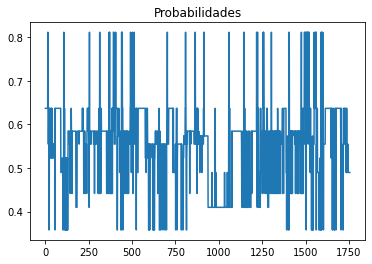

In [74]:
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

y_proba_train = melhor_modelo.predict_proba(X_train)[:,1]
y_proba_test = melhor_modelo.predict_proba(X_test)[:,1]
pd.Series(y_proba_train).plot(title = "Probabilidades")

#### Avaliação

In [75]:
# Treinamento
print(confusion_matrix(y_train, y_pred_train))
print()
print(accuracy_score(y_train, y_pred_train))
print()
print(classification_report(y_train, y_pred_train))

[[253 529]
 [186 788]]

0.5928246013667426

              precision    recall  f1-score   support

         0.0       0.58      0.32      0.41       782
         1.0       0.60      0.81      0.69       974

    accuracy                           0.59      1756
   macro avg       0.59      0.57      0.55      1756
weighted avg       0.59      0.59      0.57      1756



In [76]:
# Teste
print(confusion_matrix(y_test, y_pred_test))
print()
print(accuracy_score(y_test, y_pred_test))
print()
print(classification_report(y_test, y_pred_test))

[[135 310]
 [134 367]]

0.5306553911205074

              precision    recall  f1-score   support

         0.0       0.50      0.30      0.38       445
         1.0       0.54      0.73      0.62       501

    accuracy                           0.53       946
   macro avg       0.52      0.52      0.50       946
weighted avg       0.52      0.53      0.51       946



AUC - Teste : 0.5281033438740497


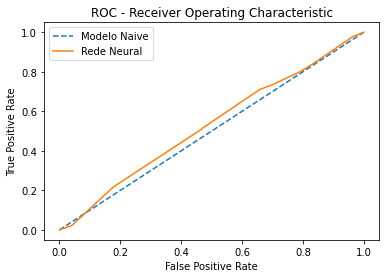

In [77]:
# Calculando a AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
print("AUC - Teste :", roc_auc)

# Criando Curva ROC
plt.plot([0,1], [0,1], linestyle = '--', label = 'Modelo Naive')
plt.plot(fpr, tpr, label = 'Rede Neural')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC - Receiver Operating Characteristic")
plt.legend()
plt.show()

#### Sinais

In [78]:
# n_q = 5

# sinais = pd.DataFrame()
# sinais["Observado"] = np.array(y_train)
# sinais["Probabilidades"] = pd.Series(y_proba_train)
# sinais["Quantil"] = pd.qcut(sinais["Probabilidades"], n_q, False)
# sinais["Intervalo_Quantil"] = pd.qcut(sinais["Probabilidades"], n_q)

##### Automatização do Ponto de Corte 2:

In [79]:
# Automatização 2:
# pares = []
# for i in range(n_q):
#     for j in range(n_q):
#         if i < j:
#             pares.append((i,j))
            
# def backtest(par):

#     lim_venda = par[0]
#     lim_compra = par[1]
    
#     corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
#     corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right
    
#     resultado = pd.DataFrame()
#     resultado["Observado"] = np.array(y_train)
#     resultado["Probabilidades"] = pd.Series(y_proba_train)
#     resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))

#     bt = pd.DataFrame()
#     bt["Alvo"] = df["Alvo_Contínuo"][ini_treino:fim_treino].reset_index(drop = True)
#     bt["Sinal"] = resultado["Operação"]
#     bt.index = df["Alvo_Contínuo"][ini_treino:fim_treino].index
#     bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, bt["Alvo"], 0))
#     bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()

#     return bt.tail(1)["Retorno Acumulado"].values

# retornos = []
# for i in pares:
#     retornos.append(backtest(i))
    
# print("Maior retorno no treinamento:", max(retornos))
# print("Quantis de Corte", pares[retornos.index(max(retornos))])

# lim_compra = pares[retornos.index(max(retornos))][1]
# lim_venda = pares[retornos.index(max(retornos))][0]

# corte_compra = sinais[sinais["Quantil"] == lim_compra]["Intervalo_Quantil"].iloc[0].left
# corte_venda = sinais[sinais["Quantil"] == lim_venda]["Intervalo_Quantil"].iloc[0].right

#### Backtest

In [80]:
corte_compra = 0.5
corte_venda = 0.5

In [81]:
bt

,Alvo,Sinal,Retorno Diário,Retorno Acumulado,Retorno BH
Data,,,,,
2016-11-01,0.016928,1,0.016928,1.016928,1.016928
2016-11-02,-0.073008,-1,0.073008,1.091172,0.942684
2016-11-03,0.023416,1,0.023416,1.116724,0.964758
2016-11-04,0.002033,-1,-0.002033,1.114454,0.966720
2016-11-07,0.011111,-1,-0.011111,1.102071,0.977461
...,...,...,...,...,...
2021-07-26,0.051173,1,0.051173,32.818726,11.410932
2021-07-27,0.017961,1,0.017961,33.408184,11.615885
2021-07-28,0.000406,1,0.000406,33.421748,11.620601


Retorno BH: [158.89604145] %
Retorno do Modelo: [250.54156584] %


<AxesSubplot:xlabel='Data'>

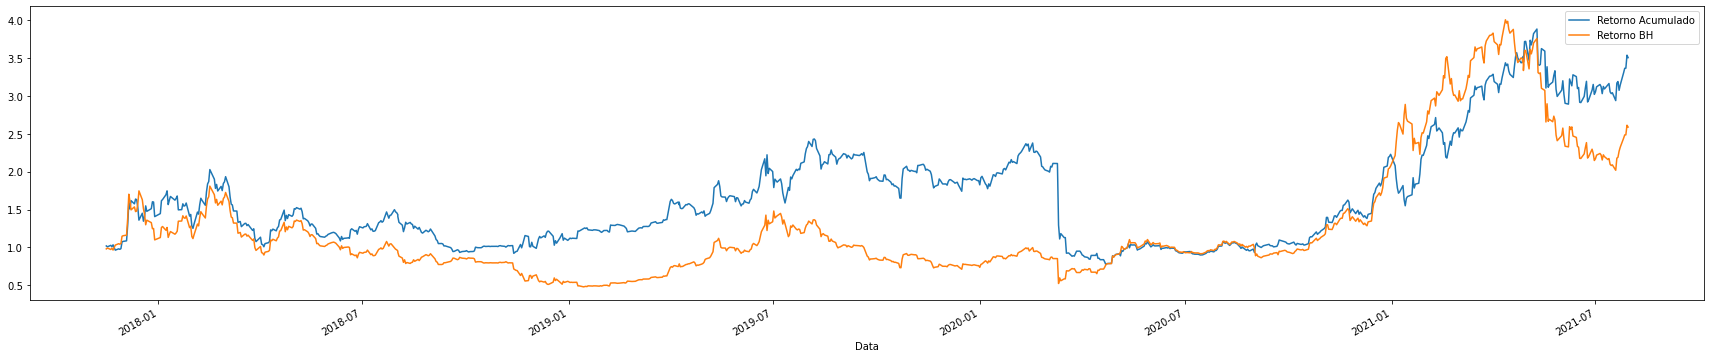

In [82]:
resultado = pd.DataFrame()
resultado["Observado"] = np.array(y_test)
resultado["Probabilidades"] = pd.Series(y_proba_test)
resultado["Operação"] = np.where(resultado["Probabilidades"] > corte_compra, 1, np.where(resultado["Probabilidades"] < corte_venda, -1, 0))
resultado["Operação"].value_counts()

bt = pd.DataFrame()
bt["Alvo"] = df["Alvo_Contínuo"][ini_teste:fim_teste].reset_index(drop = True)
bt["Sinal"] = resultado["Operação"]
bt.index = df["Alvo_Contínuo"][ini_teste:fim_teste].index

# # Acrescentando Stop
# bt = bt.join(stop_vol[ini_teste:fim_teste][["Stop_Long", "Stop_Short"]])
# bt["Retorno Long"] = np.where(bt["Sinal"] == 1, bt["Alvo"], 0)
# bt["Retorno Short"] = np.where(bt["Sinal"] == -1, -bt["Alvo"], 0)
# bt["Retorno Long"] = np.where(bt["Stop_Long"] == 1, -STOP, bt["Retorno Long"])
# bt["Retorno Short"] = np.where(bt["Stop_Short"] == 1, -STOP, bt["Retorno Short"])
# bt["Retorno Diário"] = bt["Retorno Long"] + bt["Retorno Short"]

bt["Retorno Diário"] = np.where(bt["Sinal"] == 1, bt["Alvo"], np.where(bt["Sinal"] == -1, -bt["Alvo"], 0))

bt["Retorno Acumulado"] = (bt["Retorno Diário"] + 1).cumprod()
bt["Retorno BH"] = (bt["Alvo"] + 1).cumprod()

print("Retorno BH:", (bt.tail(1)["Retorno BH"].values-1)*100, "%")
print("Retorno do Modelo:", (bt.tail(1)["Retorno Acumulado"].values-1)*100, "%")

bt[["Retorno Acumulado", "Retorno BH"]].plot(figsize=(30,6))

In [84]:
bt.to_excel("../wrangled_data/backtest65-35.xlsx")